# Preparation

In [2]:
# establish a path for a specific subject 
# this analysis can be performed either on the google drive folder of the project (if you have access) or locally 
# (for which the root and subject_figures_path have to be adapted according to the user's preference)

# try to run the code on google colab...
try:
  from google.colab import drive
  drive.mount('/content/drive/')
  shared_drive_foldername = 'NUTRECON'
  root = '/content/drive/Shareddrives/{}/'.format(shared_drive_foldername)
  subject_figures_path = root + "4. Results/1. Subject level/"
  !pip install pandas==1.4.2
  print('Running Code in Colab')
# ...or locally
except:
  # define the local directory of the project
  root = "C:/Users/DiogoMelo/nutreconDrive/"
  # define a path to save the the figures from the analysis
  subject_figures_path = "C:/Users/DiogoMelo/NUTRECON/Results/Subject Level/"
  print('Running Code locally')

# import necessary packages
import pandas as pd
import numpy as np
from datetime import datetime
from glob import glob
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
# from sklearn.linear_model import LogisticRegression
from numpy.core.fromnumeric import resize
from pathlib import Path

# append the folder containing the data acquisition Jupyter Notebooks to the system's path
sys.path.append(root + '1. Acquisition/notebooks')

# import nutrecon.py variables and functions
from nutrecon import *

# ask the user the number of the subject for analysis
subject_nr = int(input('Enter the number of the subject for analysis: '))
print('\nAnalysis will be performed on data from Subject {}'.format(subject_nr))

# object instantiation
_v_ = Vars()

# access class attributes and create instance
dataPath = _v_.dataPath

# code to identify the files corresponding to either the sequences displayed to the user or the user's responses 
experiment_code_sequences = _v_.experiment_code_sequences
experiment_code_responses = _v_.experiment_code_responses

# path for the folders containing the sequence and response files, respectively
sequences_dataPath = _v_.sequences_dataPath
responses_dataPath = _v_.responses_dataPath

# correspondance between flavors tested and single letter code
flavorCodes = _v_.flavorCodes

# correspondance between image number and shape
imageCodes = _v_.imageCodes

# map of indexes to image numbers
imageDecoder = _v_.imageDecoder

# set of file identifiers and column names for dataframes

pres_order_fileID = _v_.pres_order_fileID
pres_order_colName = _v_.pres_order_colName
flavorID_colName = _v_.flavorID_colName
flavorName_colName = _v_.flavorName_colName

pres_order_d2_fileID = _v_.pres_order_d2_fileID
pres_order_d3_fileID = _v_.pres_order_d3_fileID

# these files contain the ratings of intensity, novelty and pleasantness for each of the three days
flav_ratings_fileID = _v_.flav_ratings_fileID

intensity_colName = _v_.intensity_colName
novelty_colName = _v_.novelty_colName
pleasanteness_colName = _v_.pleasanteness_colName

# order of the four selected flavors at day 1 learnig phase
learn_order_fileID = _v_.learn_order_fileID
learningOrder_colName = _v_.learningOrder_colName
imageName_colName = _v_.imageName_colName
imageID_colName = _v_.imageID_colName

# order of flavour presentation during day 1 association test
assocTestOrder1_colName = _v_.assocTestOrder1_colName
assoc1_order_fileID = _v_.assoc1_order_fileID

# order of flavour presentation during day 2 association test
assocTestOrder2_colName = _v_.assocTestOrder2_colName
assoc2_order_fileID = _v_.assoc2_order_fileID

# order of flavour presentation during day 3 association test
assocTestOrder3_colName = _v_.assocTestOrder3_colName
assoc3_order_fileID = _v_.assoc3_order_fileID

neuroEconOrder1_fileID = _v_.neuroEconOrder1_fileID
neuroEconOrder2_fileID = _v_.neuroEconOrder2_fileID

conditioning_order_fileID = _v_.conditioning_order_fileID
conditioning_order_colName = _v_.conditioning_order_colName

ratings_id = _v_.ratings_id
orders_id = _v_.orders_id

# create a directory to save the results of the current subject 
subject_code_responses = '{}{:03d}'.format(experiment_code_responses, subject_nr)
subject_figures_path_responses = subject_figures_path + subject_code_responses
Path(subject_figures_path_responses).mkdir(parents=True, exist_ok=True)

# find the file containing learning order of the falvors at day 1
subject_code_sequences = '{}{:03d}'.format(experiment_code_sequences, subject_nr)
learning_path = glob('{}{}*{}*'.format(sequences_dataPath, subject_code_sequences, learn_order_fileID))[0]
learning_df = pd.read_json(learning_path).T
learning_df[flavorName_colName].tolist()

# find the file containing all the information on the neuroeconomis task realized at day 2
neuroEcon_id = _v_.neuroEcon_id
neuroEcon_df = pd.read_json(glob('{}{}*{}*'.format(responses_dataPath, subject_code_responses, neuroEcon_id))[0])

# search within the neuroeconomics dataframe which flavors are paired/not paired with nutrient (Cplus and Cminus)
flavor_Cplus = neuroEcon_df[neuroEcon_df['Trial Type'] == 'mixed_yogurt'].iloc[0]['reference flavor']
flavor_Cminus = neuroEcon_df[neuroEcon_df['Trial Type'] == 'mixed_yogurt'].iloc[0]['lottery flavor']

marker_order = ['^' if flavor == flavor_Cplus else 'v' if flavor == flavor_Cminus else 'o' if flavor in learning_df[flavorName_colName].tolist() else 'x' for flavor in list(flavorCodes.keys())]

Running Code locally
Running Code locally

Analysis will be performed on data from Subject 2


# Ratings

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.2980392156862745, 0.4470588235294118, 0.6901960784313725)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.8666666666666667, 0.5176470588235295, 0.3215686274509804)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.5764705882352941, 0.47058823529411764, 0.3764705882352941)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior

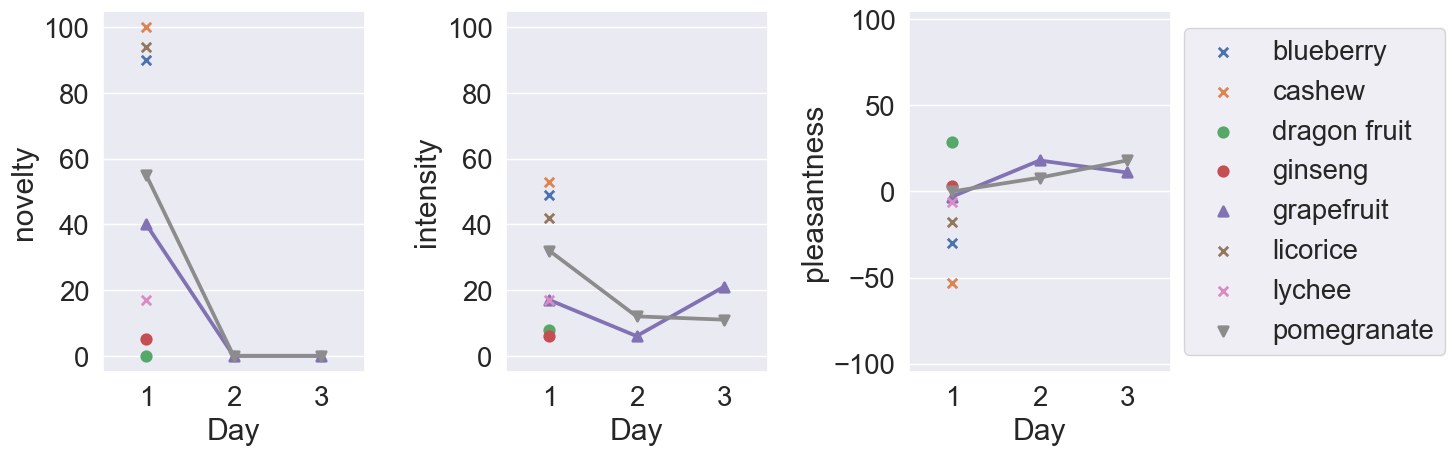

In [3]:
# ratings of novelty, intensity and pleasentness are taken at day 1 or 8 different flavors,
# from the 8, only 2 are selected to perform the neuroeconomics task at days 2 and 3, according to rating based criteria:
# A. flavours are not unpleasant
# B. flavours that are moderately pleasant
# C. flavours that are novel

# search for the rating files from days 1, 2 and 3
ratings_paths = glob('{}{}*{}*'.format(responses_dataPath, subject_code_responses, ratings_id))

# format marker size
marker_scale = 1

for ratings_path in ratings_paths:
  # open ratings json file as a dataframe 
  dayRating_df = pd.read_json(ratings_path)
  # divide ratings path name in atributes for search of flavor presentation order files
  fpath, day, preOrder, timestamp =  ratings_path.split('_')
  fpath = fpath.replace('responses', 'sequences')
  fpath = fpath.replace(subject_code_responses, subject_code_sequences)
  order_path = glob('{}_{}{}*'.format(fpath.replace('responses', 'sequences'), day, orders_id))[0]
  dayOrder_df = pd.read_json(order_path).T
  dayOrder_df['Trial'] = np.arange(len(dayOrder_df)) + 1
  dayRating_df = dayRating_df.merge(dayOrder_df[[flavorName_colName, flavorID_colName, 'Trial']], left_on = 'Trial', right_on = 'Trial')
  if ratings_path == ratings_paths[0]:
    ratings_df = dayRating_df
  else:
    ratings_df = pd.concat([ratings_df, dayRating_df])

sns.set_theme(font_scale = 1.8)
fig, ax = plt.subplots(ncols = 3, figsize = [15,5])

sns.pointplot(data = ratings_df, x = 'Day', y = novelty_colName, hue = flavorName_colName, hue_order = list(flavorCodes.keys()),
              markers = marker_order, scale=marker_scale, order = [1,2,3], ax = ax[0], legend = False)
ax[0].set_ylim([-5,105]);
ax[0].get_legend().remove();

sns.pointplot(data = ratings_df, x = 'Day', y = intensity_colName, hue = flavorName_colName, hue_order = list(flavorCodes.keys()),
              markers = marker_order, scale=marker_scale, order = [1,2,3], ax = ax[1])
ax[1].set_ylim([-5,105]);
ax[1].get_legend().remove();

sns.pointplot(data = ratings_df, x = 'Day', y = pleasanteness_colName, hue = flavorName_colName, hue_order = list(flavorCodes.keys()),
              markers = marker_order, scale=marker_scale, order = [1,2,3], ax = ax[2])
ax[2].set_ylim([-105,105]);
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

fig.savefig(subject_figures_path_responses + '/ratings.png')

# Association Tests

### Day 1

			Accuracy: 1.0


precision  recall  f1-score        Flavor
criteria      image_id flavor_id                                           
in compliance Image I  i                1.0     1.0       1.0       ginseng
              Image II e                1.0     1.0       1.0   pomegranate
              Image V  h                1.0     1.0       1.0  dragon fruit
              Image VI j                1.0     1.0       1.0    grapefruit

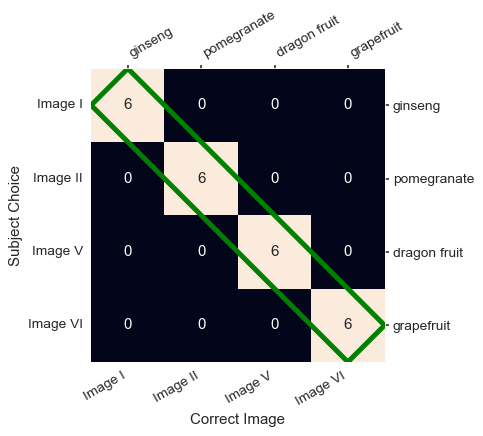

In [4]:
sns.set_theme(font_scale = 1)

# set a minimum of correct responses
min_correctResp = 4

associationTest1_df, _ = loadResponses(sequences_dataPath, assoc1_order_fileID, subject_code_sequences)
imageFlavor_df, _ = loadResponses(sequences_dataPath, learn_order_fileID, subject_code_sequences)
flavorImage_code = {p[imageID_colName]:p[flavorName_colName] for p in imageFlavor_df.T[[imageID_colName, flavorName_colName]].to_dict('index').values()}
atest_day1_sequence = [get_key(imageDecoder,p) for p in associationTest1_df.T['image_id'].tolist()]
atest_day1_responses, _ = loadResponses(responses_dataPath, 'day1_atest', subject_code_responses)

fig, report = reportAndConfusionMatrix(atest_day1_sequence, atest_day1_responses['image_id'].tolist(), flavorImage_code)
plt.tight_layout()
fig.savefig(subject_figures_path_responses + '/atest1.png', transparent=True)
check_atest(report, flavorImage_code, min_correctResp)

### Day 2

			Accuracy: 1.0


precision  recall  f1-score       Flavor
criteria      image_id flavor_id                                          
in compliance Image II e                1.0     1.0       1.0  pomegranate
              Image VI j                1.0     1.0       1.0   grapefruit

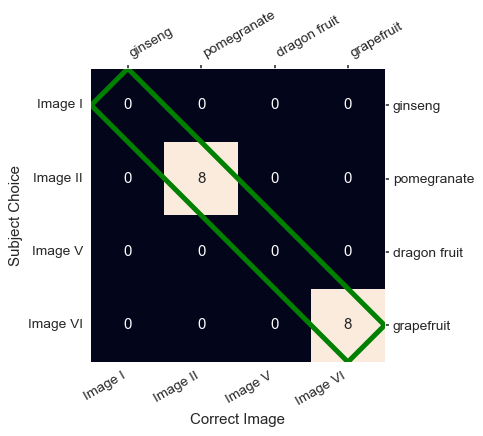

In [5]:
subject_code = subject_code_sequences

# set a minimum of correct responses
min_correctResp = 7

associationTest2_df, _ = loadResponses(sequences_dataPath, assoc2_order_fileID, subject_code)
imageFlavor_df, _ = loadResponses(sequences_dataPath, learn_order_fileID, subject_code)
flavorImage_code = {p[imageID_colName]:p[flavorName_colName] for p in imageFlavor_df.T[[imageID_colName, flavorName_colName]].to_dict('index').values()}
atest_day2_sequence = [get_key(imageDecoder,p) for p in associationTest2_df.T['image_id'].tolist()]
atest_day2_responses, _ = loadResponses(responses_dataPath, 'day2_atest', subject_code_responses)

fig, report = reportAndConfusionMatrix(atest_day2_sequence, atest_day2_responses['image_id'].tolist(), flavorImage_code)
plt.tight_layout()
fig.savefig(subject_figures_path_responses + '/atest2.png', transparent=True)
check_atest(report, flavorImage_code, min_correctResp)

### Day 3

			Accuracy: 1.0


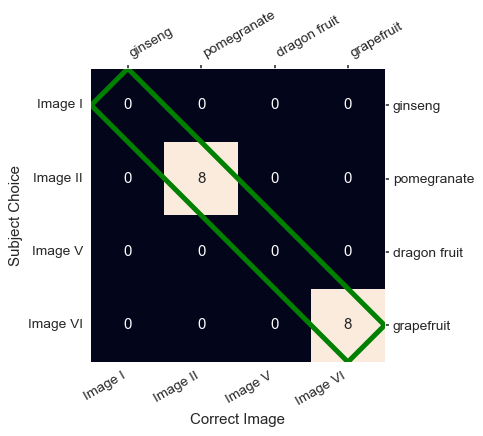

In [6]:
subject_code = subject_code_sequences

# set a minimum of correct answers
min_correctResp = 7

associationTest3_df, _ = loadResponses(sequences_dataPath, assoc3_order_fileID, subject_code)
imageFlavor_df, _ = loadResponses(sequences_dataPath, learn_order_fileID, subject_code)
flavorImage_code = {p[imageID_colName]:p[flavorName_colName] for p in imageFlavor_df.T[[imageID_colName, flavorName_colName]].to_dict('index').values()}
atest_day3_sequence = [get_key(imageDecoder,p) for p in associationTest3_df.T['image_id'].tolist()]
atest_day3_responses, _ = loadResponses(responses_dataPath, 'day3_atest', subject_code_responses)

if _ != None:
  fig, report = reportAndConfusionMatrix(atest_day3_sequence, atest_day3_responses['image_id'].tolist(), flavorImage_code)
  plt.tight_layout()
  fig.savefig(subject_figures_path_responses + '/atest3.png', transparent=True)
  check_atest(report, flavorImage_code, min_correctResp)

# Reaction times

In [7]:
neuroEcon_paths = glob('{}{}*{}*'.format(responses_dataPath, subject_code_responses, neuroEcon_id))
neuroEcon_path = neuroEcon_paths[0]
print(neuroEcon_path)

'''
Trial choice:
2 - reference option
1 - lottery option
0 - missed trial
'''

for neuroEcon_path in neuroEcon_paths:
  dayNeuroEcon_df = pd.read_json(neuroEcon_path)
  if neuroEcon_path == neuroEcon_paths[0]:
    neuroEcon_df = dayNeuroEcon_df
  else:
    neuroEcon_df = pd.concat([neuroEcon_df, dayNeuroEcon_df])
neuroEcon_df['reaction_time'] = neuroEcon_df['choiceTime_ms'] - neuroEcon_df['choiceStart_ms']
neuroEcon_df['Day'] = neuroEcon_df['Day'].apply(lambda day: int(day[-1]))

neuroEcon_df.columns

C:/Users/DiogoMelo/nutreconDrive/2. demoData/raw/nutrecon/responses\exampleSub002_day2_neuroEcon_1669971545.json


Index(['Day', 'Trial', 'Trial ID', 'Trial Type', 'User', 'block', 'choice',
       'choiceStart_ms', 'choiceTime', 'choiceTime_ms', 'feedbackTime',
       'lottery flavor', 'lottery p', 'lottery qt', 'lottery shape',
       'lottery type', 'optionTime', 'reference flavor', 'reference p',
       'reference qt', 'reference shape', 'reference type',
       'trialStartTimestamp', 'trialStart_ms', 'reaction_time'],
      dtype='object')

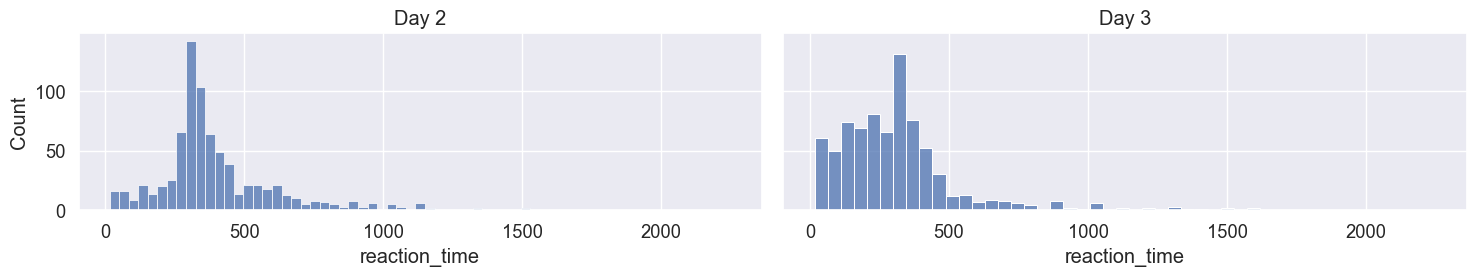

In [8]:
sns.set_theme(font_scale = 1.2)
fig, ax = plt.subplots(ncols = 2, figsize = [15,3], sharey = True, sharex = True)
c = 0
for day in neuroEcon_df['Day'].unique():
  sns.histplot(data = neuroEcon_df[neuroEcon_df['Day'] == day], x = 'reaction_time', ax = ax[c])
  ax[c].set_title('Day {}'.format(day))
  c+=1
plt.tight_layout()
fig.savefig(subject_figures_path_responses + '/reaction_time.png')

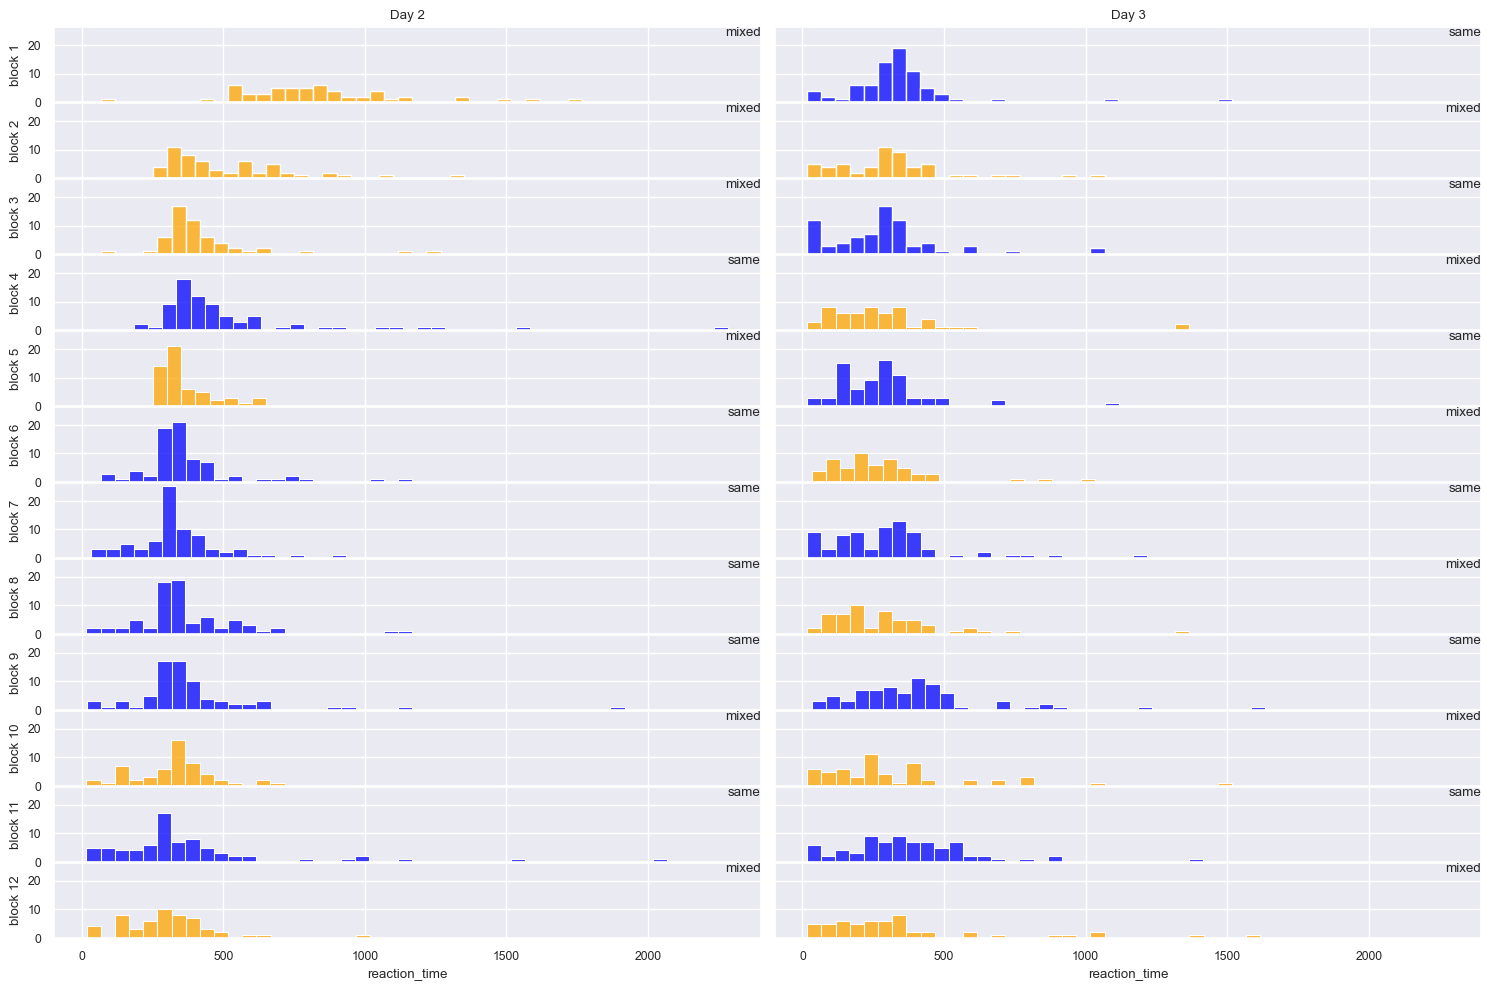

In [9]:
sns.set_theme(font_scale = .8)
fig, ax = plt.subplots(ncols = 2, nrows = len(neuroEcon_df['block'].unique()), figsize = [15,10], sharex = True, sharey = True)

row = 0

for block in neuroEcon_df['block'].unique():
  df_ = neuroEcon_df[neuroEcon_df['block'] == block]  
  col = 0
  for day in df_['Day'].unique():
    block_type = df_[df_['Day'] == day]['Trial Type'].tolist()[0]
    if block_type == 'same':
      color = 'blue'
    else:
      block_type = 'mixed'
      color = 'orange'
    sns.histplot(data = df_[df_['Day'] == day], x = 'reaction_time', ax = ax[row, col],  binwidth=50, color = color)
    ax[row,col].set_ylabel('')
    ax[row,col].text(1,1,block_type, ha='right', va = 'top', transform = ax[row,col].transAxes)
    col+=1
  ax[row,0].set_ylabel('block {}'.format(block + 1))
    
  row += 1

ax[0,0].set_title('Day 2')
ax[0,1].set_title('Day 3')
plt.tight_layout(h_pad = -.5)
fig.savefig(subject_figures_path_responses + '/block_reactionTime.png')

## missed trials

In [10]:
zero_counts_df = pd.DataFrame()
try:
  answer_counts_df = pd.DataFrame(neuroEcon_df[['Day', 'Trial Type', 'lottery type','choice']].groupby(['Day', 'Trial Type', 'lottery type']).value_counts(), columns=['count'])
  zero_counts_df = answer_counts_df[answer_counts_df.index.get_level_values('choice') == 0]
except Exception as e:
  print(e)
zero_counts_df

,,,,count
Day,Trial Type,lottery type,choice,
2,same,C-,0,1


# Parameter estimation (alphas and beta)

## Same-Type

In [11]:
column_names = ['reference type', 'reference qt', 'reference p',
                'lottery type', 'lottery qt', 'lottery p',
                'ref_alpha', 'lott_alpha', 'beta',
                'ref_EU', 'lott_EU', 'pL', 'choice',
                'ref_alphaEstimates', 'lott_alphaEstimates', 'betaEstimates',
                'ref_alphaEstimStdErr', 'lott_alphaEstimStdErr', 'betaEstimStdErr']

optimize_cols = column_names[:6]  + [column_names[12]]

# compute expected utility
def get_EU_(p,X, alpha):
  # This value is obtained by multiplying the probability of recieving a specific reward associated with a choice by the real value of the reward. Furthermore, the real value is raised to the power of an alpha parameter
  # which represents the subject-by-subject level of risk aversion for a specific reward type. If alpha > 1, the indiviudal is considered a risk seaker and if alpha < 1, the individual is considered risk averse.
  return p * X**alpha

# Probability of chosing lottery given the expected utility of both choices (logistic function)
def get_pL_(euL, euR, beta):
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))

# this function nests get_pL_ to compute the likelihood of the evidence (choices) given the hypothesis (internal parameters of the model)
# observational model (the function I want to maximize; I want to see "where" is the maximum of this function, which is to say, I want to find the internal model parameters for which this function peaks...
# ...OR, which are the parameters that better explain my evidence (in this case, observed behavior in the form of trial by trial choices)) 
def get_likelihood(row, params, cols = optimize_cols):
  ref_type = row[cols[0]]
  lott_type = row[cols[3]]
  # considering beta is not reward type specific
  if len(params) == 4:
    (alpha_money, alpha_Cplus, alpha_Cminus, beta) = params
    alphas = {'money' : alpha_money,
             'C+' : alpha_Cplus,
             'C-' : alpha_Cminus}
    ref_alpha = alphas[ref_type]
    lott_alpha = alphas[lott_type]
  # considering beta as reward type specific
  elif len(params) == 6:
    (alpha_money, alpha_Cplus, alpha_Cminus, beta_money, beta_Cplus, beta_Cminus) = params
    alphas = {'money' : alpha_money,
             'C+' : alpha_Cplus,
             'C-' : alpha_Cminus}
    betas = {'money' : beta_money,
             'C+' : beta_Cplus,
             'C-' : beta_Cminus}
    ref_alpha = alphas[ref_type]
    lott_alpha = alphas[lott_type]
    beta = betas[lott_type]
  
  choice = row[cols[6]]

  ref_X = row[cols[1]]
  ref_p = row[cols[2]]
  ref_EU = get_EU_(ref_p, ref_X, ref_alpha)
  
  lott_X = row[cols[4]]
  lott_p = row[cols[5]]
  lott_EU = get_EU_(lott_p, lott_X, lott_alpha)

  pL = get_pL_(lott_EU, ref_EU, beta)
  if choice == 1:
    likelihood = pL
  else:
    likelihood = 1 - pL
  return likelihood

# working with the log of the likelihood instead of the likelihood directly is numerically more stable
# if you print negloglikelihood and run the following cell, you will notice that the likelihood distribution of the parameters is not continuous in the whole space (goes to infinite for some parameter combinations)
def get_negLogLikelihood(params, args):
  df = args
  task_cols = optimize_cols
  # compute likelihood of each choice
  likelihood = df.apply(lambda row: get_likelihood(row, params, cols = task_cols), axis=1).values
  # print(likelihood)
  # plt.plot(np.arange(0, len(likelihood)), likelihood)
  # plt.show()
  # Take negative of logLikelihood for convention
  negloglikelihood = - np.sum(np.log(likelihood))
  return negloglikelihood

### Day 2

In [12]:
alphaMoney_d2 = 0
alphaCplus_d2 = 0
alphaCminus_d2 = 0
beta_d2 = 0

df_day2 = neuroEcon_df[neuroEcon_df['Day'] == 2]

# create a new dataframe containing only the same type trials
df_sameType_d2 = df_day2[df_day2['Trial Type'] == 'same']
# what does 2, 1 and 0 mean, and why are there other values
df_sameType_d2['choice'] = np.where(df_sameType_d2['choice'] == 2, 1, 0)

args_d2_ST = (df_sameType_d2)
# starting guess
x0_d2_ST = (alphaMoney_d2, alphaCplus_d2, alphaCminus_d2, beta_d2)
# in order to obtain to most likely parameters, we take the negative of the log likelihood function and minimize it
res_d2_ST = minimize(get_negLogLikelihood, x0_d2_ST, args=args_d2_ST)

# hessian - variance and covariance (how peaked is the function maximum); inverse hessian - how spread is the log likelihood function around the maximum
# the reverse hessian (matrix containing the second derivative of the likelihood function with respect to the internal model parameters) can be use to compute confidence intervals
parsCI_d2_ST = ['{} \xb1 {}'.format(round(res_d2_ST.x[p],3), round(1.96*np.sqrt(np.diag(res_d2_ST.hess_inv))[p],3)) for p in range(len(res_d2_ST.x))]

alpha_money_d2 = parsCI_d2_ST[0]
alpha_cPlus_d2 = parsCI_d2_ST[1]
alpha_cMinus_d2 = parsCI_d2_ST[2]

print('\nDay 2 parameters:')
print('  - {}: {}'.format('alpha Money', parsCI_d2_ST[0]))
print('  - {}: {}'.format('alpha C+', parsCI_d2_ST[1]))
print('  - {}: {}'.format('alpha C-', parsCI_d2_ST[2]))
print('  - {}: {}'.format('beta', parsCI_d2_ST[3]))

C:\Users\DiogoMelo\AppData\Local\Temp\ipykernel_16292\4235648160.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sameType_d2['choice'] = np.where(df_sameType_d2['choice'] == 2, 1, 0)
C:\Users\DiogoMelo\AppData\Local\Temp\ipykernel_16292\1001638025.py:75: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
C:\Users\DiogoMelo\AppData\Local\Temp\ipykernel_16292\1001638025.py:75: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
c:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\DiogoMelo\AppData\Local\Temp\ipykernel_16292\1001638025.py:75: R


Day 2 parameters:
  - alpha Money: 0.626 ± 0.064
  - alpha C+: 0.317 ± 0.048
  - alpha C-: 0.057 ± 0.077
  - beta: 4.345 ± 0.461


### Day 3

In [13]:
alphaMoney_d3 = 0
alphaCplus_d3 = 0
alphaCminus_d3 = 0
beta_d3 = 0

df_day3 = neuroEcon_df[neuroEcon_df['Day'] == 3]

if len(df_day3) > 0:
  df_sameType_d3 = df_day3[df_day3['Trial Type'] == 'same']
  df_sameType_d3['choice'] = np.where(df_sameType_d3['choice'] == 2, 1, 0)
  
  args_d3_ST = (df_sameType_d3)
  x0_d3_ST = (alphaMoney_d3, alphaCplus_d3, alphaCminus_d3, beta_d3)
  res_d3_ST = minimize(get_negLogLikelihood, x0_d3_ST, args=args_d3_ST)

  parsCI_d3_ST = ['{} \xb1 {}'.format(round(res_d3_ST.x[p],3), round(1.96*np.sqrt(np.diag(res_d3_ST.hess_inv))[p],3)) for p in range(len(res_d3_ST.x))]

  print('\nDay 2 parameters:')
  print('  - {}: {}'.format('alpha Money', parsCI_d2_ST[0]))
  print('  - {}: {}'.format('alpha C+', parsCI_d2_ST[1]))
  print('  - {}: {}'.format('alpha C-', parsCI_d2_ST[2]))
  print('  - {}: {}'.format('beta', parsCI_d2_ST[3]))

  print('\nDay 3 parameters:')
  print('  - {}: {}'.format('alpha Money', parsCI_d3_ST[0]))
  print('  - {}: {}'.format('alpha C+', parsCI_d3_ST[1]))
  print('  - {}: {}'.format('alpha C-', parsCI_d3_ST[2]))
  print('  - {}: {}'.format('beta', parsCI_d3_ST[3]))
else:
  print('\nDay 2 parameters:')
  print('  - {}: {}'.format('alpha Money', parsCI_d2_ST[0]))
  print('  - {}: {}'.format('alpha C+', parsCI_d2_ST[1]))
  print('  - {}: {}'.format('alpha C-', parsCI_d2_ST[2]))
  print('  - {}: {}'.format('beta', parsCI_d2_ST[3]))
  print('\nDay 3 responses not loaded')

C:\Users\DiogoMelo\AppData\Local\Temp\ipykernel_16292\2682996993.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sameType_d3['choice'] = np.where(df_sameType_d3['choice'] == 2, 1, 0)
C:\Users\DiogoMelo\AppData\Local\Temp\ipykernel_16292\1001638025.py:75: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
C:\Users\DiogoMelo\AppData\Local\Temp\ipykernel_16292\1001638025.py:75: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
c:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\DiogoMelo\AppData\Local\Temp\ipykernel_16292\1001638025.py:75: R


Day 2 parameters:
  - alpha Money: 0.626 ± 0.064
  - alpha C+: 0.317 ± 0.048
  - alpha C-: 0.057 ± 0.077
  - beta: 4.345 ± 0.461

Day 3 parameters:
  - alpha Money: 0.329 ± 0.044
  - alpha C+: 0.037 ± 0.133
  - alpha C-: 0.335 ± 0.039
  - beta: 5.292 ± 2.477


# NeuroEcon choice plots
# Same-type trials


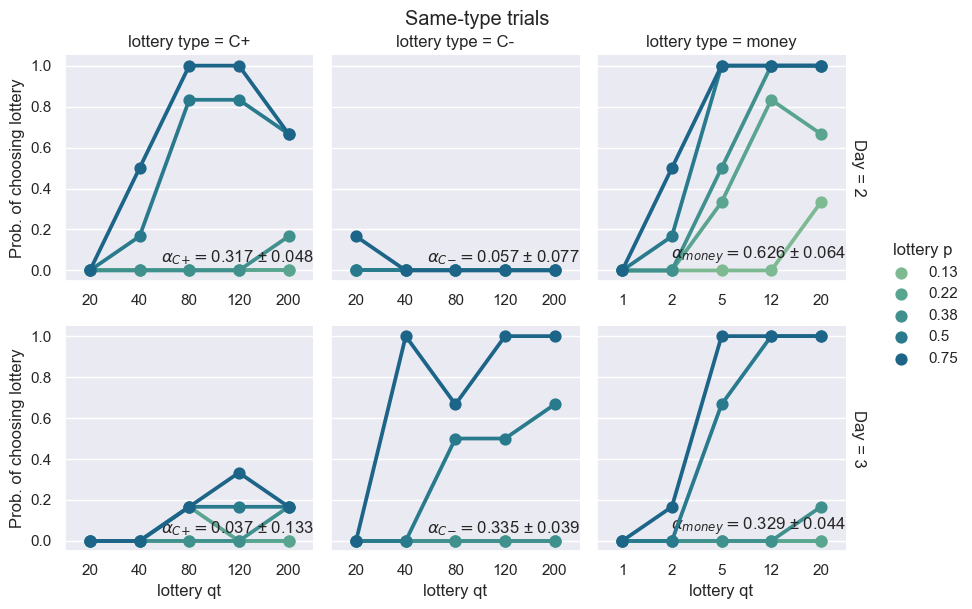

In [14]:
probLotteryChoice_colName = 'Prob. of choosing lottery'

def get_reward_choice(row):
  if row['choice'] == 1:
    reward = row['reference type']
  elif row['choice'] == 2:
    reward = row['lottery type']
  else:
    reward = ''

  return reward

def get_choice_side(row):
  if row['choice'] == 1:
    reward = 'reference'
  elif row['choice'] == 2:
    reward = 'lottery'
  else:
    reward = ''

  return reward

def get_probLottery(group):
  prob_lotteryChoice = len(group[group['choice'] == 2]) / 6
  return prob_lotteryChoice

def plot_st_recap(df, st_color):

  fig, ax = plt.subplots(figsize = [3,3])
  sns.countplot(data=df, x='chosen option', order = ['reference', 'lottery'], palette=[tuple(c*.5 for c in st_color), st_color]);
  plt.tight_layout()
  #fig.savefig('mixedYogurt_choicesD2.png')


  grid = sns.FacetGrid(data=df, row = 'lottery qt', col = 'lottery p',height=2,aspect=1, margin_titles = True, sharey = True)
  fig = grid.map_dataframe(sns.countplot, x='chosen option', order = ['reference', 'lottery'], palette=[tuple(c*.5 for c in st_color), st_color])
  fig.add_legend()
  plt.tight_layout()


neuroEcon_df['chosen reward'] = neuroEcon_df.apply(lambda row: get_reward_choice(row), axis = 1)
neuroEcon_df['chosen option'] = neuroEcon_df.apply(lambda row: get_choice_side(row), axis = 1)


c_palette = sns.color_palette()

cPlus_color = c_palette[0]
cMinus_color = c_palette[1]
money_color = c_palette[2]

neuroEcon_st_df = neuroEcon_df[neuroEcon_df['Trial Type'] == 'same']

grouped_st_df = pd.DataFrame(neuroEcon_st_df.groupby(['Day', 'lottery type', 'lottery p', 'lottery qt']).apply(lambda df: get_probLottery(df)), 
        columns = [probLotteryChoice_colName]).reset_index()
sns.set_theme(font_scale = 1)

fg = sns.catplot(data= grouped_st_df, row = 'Day', col="lottery type", 
    x="lottery qt", y=probLotteryChoice_colName, hue="lottery p", 
    kind = 'point', palette = sns.color_palette("crest"),
    height=3, aspect = 1,
    sharex=False, margin_titles = True
    )

alpha_label = [r'$\alpha_{C\plus}= $', r'$\alpha_{C\minus}= $', r'$\alpha_{money}= $',
               r'$\alpha_{C\plus}= $', r'$\alpha_{C\minus}= $', r'$\alpha_{money}= $']
alpha_values = [parsCI_d2_ST[1], parsCI_d2_ST[2], parsCI_d2_ST[0],
                parsCI_d3_ST[1], parsCI_d3_ST[2], parsCI_d3_ST[0]]
c = 0
for ax in fg.axes.flat:  # iterate through each subplot
    ax.text(1,0.06, '{}{}'.format(alpha_label[c],alpha_values[c]), size=12, ha="right", va = 'bottom',
         transform=ax.transAxes)
    c+=1

plt.suptitle('Same-type trials', va = 'bottom');
plt.savefig(subject_figures_path_responses + '/sameType_probPlots.png')


# Mixed iogurt preference

C:\Users\DiogoMelo\AppData\Local\Temp\ipykernel_16292\3438193989.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuroEcon_my_df['mixed-yogurt trial-type'] = neuroEcon_my_df.apply(lambda row: get_mixedYogurt_trialType(row), axis = 1)


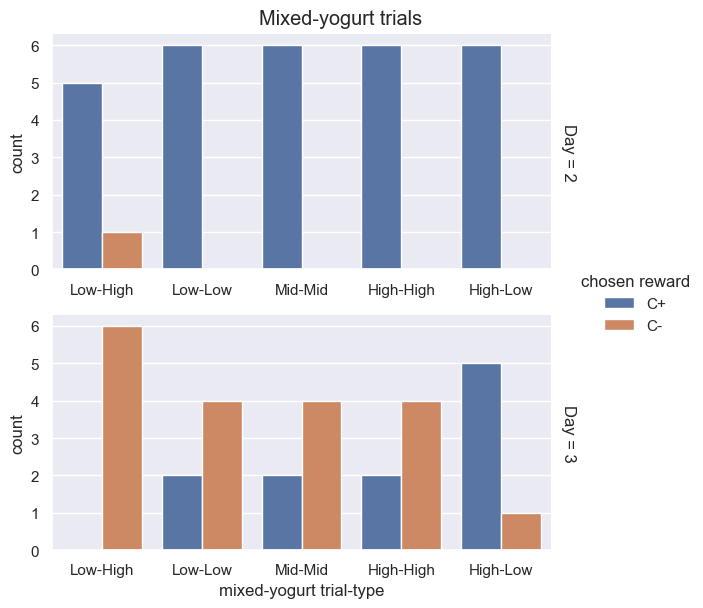

In [15]:
my_palette = [sns.color_palette("rocket")[1]] + 3 * [sns.color_palette("rocket")[3]] + [sns.color_palette("rocket")[1]] 

def get_mixedYogurt_trialType(row):
  if row['lottery p'] == row['reference p']:
    if row['lottery p'] == .13:
      trialType = 'Low-Low'
    elif row['lottery p'] == .5:
      trialType = 'Mid-Mid'
    elif row['lottery p'] == .75:
      trialType = 'High-High'
  elif row['lottery p'] > row['reference p']:
    trialType = 'Low-High'
  else:
    trialType = 'High-Low'
  return trialType

def get_cPlusChoices(group):
  cPlus_choices = len(group[group['choice'] == 1])
  return int(cPlus_choices)

neuroEcon_my_df = neuroEcon_df[neuroEcon_df['Trial Type'] == 'mixed_yogurt']
neuroEcon_my_df['mixed-yogurt trial-type'] = neuroEcon_my_df.apply(lambda row: get_mixedYogurt_trialType(row), axis = 1)
grouped_my_df = pd.DataFrame(neuroEcon_my_df.groupby(['Day', 'mixed-yogurt trial-type']).apply(lambda df: get_cPlusChoices(df)), 
        columns = ['C+ choice count']).reset_index()

sns.catplot(data= neuroEcon_my_df, row = 'Day', 
    x='mixed-yogurt trial-type', hue= 'chosen reward',
    kind = 'count', order = ['Low-High', 'Low-Low', 'Mid-Mid', 'High-High', 'High-Low'],
    hue_order = ['C+', 'C-'], 
    height=3, aspect = 2, palette= [cPlus_color, cMinus_color],
    sharex=False, margin_titles = True
    )

plt.suptitle('Mixed-yogurt trials', va = 'bottom');
plt.savefig(subject_figures_path_responses + '/mixedYogurt_Choices.png')

# Mixed-type trials

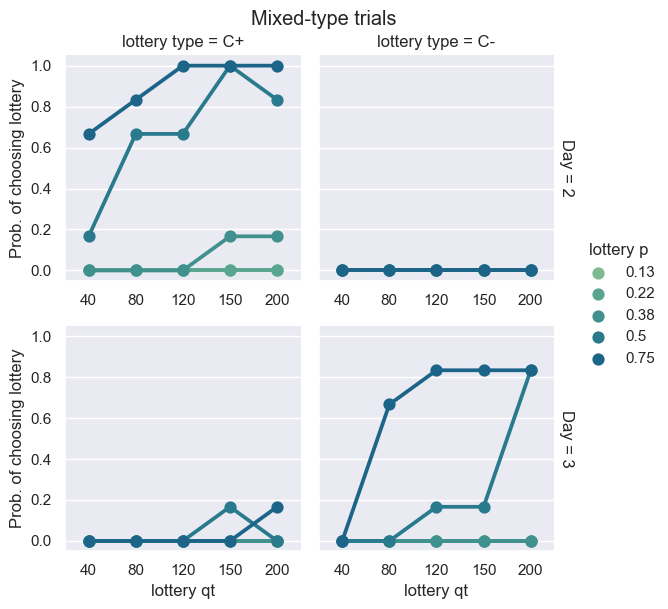

In [16]:
neuroEcon_mt_df = neuroEcon_df[neuroEcon_df['Trial Type'] == 'mixed']

grouped_mt_df = pd.DataFrame(neuroEcon_mt_df.groupby(['Day', 'lottery type', 'lottery p', 'lottery qt']).apply(lambda df: get_probLottery(df)), 
        columns = [probLotteryChoice_colName]).reset_index()
sns.set_theme(font_scale = 1)

sns.catplot(data= grouped_mt_df, row = 'Day', col="lottery type", 
    x="lottery qt", y=probLotteryChoice_colName, hue="lottery p", 
    kind = 'point', palette = sns.color_palette("crest"),
    height=3, aspect = 1,
    sharex=False, margin_titles = True
    )
plt.suptitle('Mixed-type trials', va = 'bottom');
plt.savefig(subject_figures_path_responses + '/mixedType_probPlots.png')

# Parameter Estimation (behavioral scaling factors)

## Mixed-type trials

Levy and Glimcher, 2011:

- "Using the fitted parameters from the same-type trials and the choice data from the mixed-type trials, we estimated the relative pricing between money and food and water for each subject"
- "We fit the mixed-type choice data for each chooser with the alpha term **fixed** at the values determined for the larger same-type trial data set"

**For now, I wont consider the alpha and beta parameters as having an error associated to their estimation**

In [19]:
column_names = ['reference type', 'reference qt', 'reference p',
                'lottery type', 'lottery qt', 'lottery p',
                'ref_alpha', 'lott_alpha', 'beta',
                'ref_EU', 'lott_EU', 'pL', 'choice',
                'ref_alphaEstimates', 'lott_alphaEstimates', 'betaEstimates',
                'ref_alphaEstimStdErr', 'lott_alphaEstimStdErr', 'betaEstimStdErr',
                'scal_factor_CplusEstimates', 'scal_factor_CplusEstimStdErr',
                'scal_factor_CminusEstimates', 'scal_factor_CminusEstimStdErr']

optimize_cols = column_names[:6]  + [column_names[12]]

# the parsCI argument corresponds to the estimated alpha and beta parameters, which are needed to estimate the scaling factors
parsCI = int(input("For what day of the task do you want to estimate the behavioral scaling factors (write either 2 ou 3): "))

if parsCI == 2:
  parsCI = parsCI_d2_ST
  print('You can only use this values to estimate the scaling factors for day 2 task')
elif parsCI == 3:
  parsCI = parsCI_d3_ST
  print('You can only use this values to estimate the scaling factors for day 3 task')
else:
  print('Not a valid day! Please re-run this cell and select wither 2 ou 3')

# compute expected utility
def get_EU_(p,X, reward_type, parsCI = parsCI):
  # This value is obtained by multiplying the probability of recieving a specific reward associated with a choice by the real value of the reward. Furthermore, the real value is raised to the power of an alpha parameter
  # which represents the subject-by-subject level of risk aversion for a specific reward type. If alpha > 1, the indiviudal is considered a risk seaker and if alpha < 1, the individual is considered risk averse.
  if reward_type == 'money':
    alpha = float(parsCI[0].split(' ')[0])
  elif reward_type == 'C+':
    alpha = float(parsCI[1].split(' ')[0])
  elif reward_type == 'C-':
    alpha = float(parsCI[2].split(' ')[0])
  return p * X**alpha

# Probability of chosing lottery given the expected utility of both choices (logistic function)
# In this case, I am taking into account mixed type trials in which the reference option is money and the lottery option is C+ or C-
# Note that multiplying by a scaling factor nests the same type trials, in which the scaling factor is 1
def get_pL_(euL, euR, scaling_factor, parsCI = parsCI):
  # get beta value estimated for same type trials
  beta = float(parsCI[3].split(' ')[0])
  return 1 - 1/(1 + np.exp(beta * (euL * scaling_factor - euR)))

# this function nests get_pL_ to compute the likelihood of the evidence (choices) given the hypothesis (internal parameters of the model)
# observational model (the function I want to maximize; I want to see "where" is the maximum of this function, which is to say, I want to find the internal model parameters for which this function peaks...
# ...OR, which are the parameters that better explain my evidence (in this case, observed behavior in the form of trial by trial choices)) 

# Added parsCI = parsCI as input. parsCI contains the alphas necessary for computing expected utilities
def get_likelihood(row, params, cols = optimize_cols, parsCI = parsCI):
  # search for the reward type of the reference option
  ref_type = row[cols[0]]
  # search for the reward type of the lottery option
  lott_type = row[cols[3]]

  # not sure if this should include beta
  (scaling_factor_Cplus, scaling_factor_Cminus) = params # parameters I want to estimate
  
  scaling_factors = {'C+' : scaling_factor_Cplus,
                      'C-' : scaling_factor_Cminus}

  choice = row[cols[6]]

  ref_X = row[cols[1]]
  ref_p = row[cols[2]]
  # Switched the ref_alpha for [ref_type, parsCI] that allow me to get the alpha values for the same type trials
  ref_EU = get_EU_(ref_p, ref_X, ref_type, parsCI)
  
  lott_X = row[cols[4]]
  lott_p = row[cols[5]]
  # Switched the lott_alpha for [lott_type, parsCI] that allow me to get the alpha values fo rthe same type trials
  lott_EU = get_EU_(lott_p, lott_X, lott_type, parsCI)

  # Added scaling_factor which is now necessary for computing likelihood
  pL = get_pL_(lott_EU, ref_EU, scaling_factors[lott_type], parsCI)
  # 0 - chosing the reference option; 1 - chosing the lottery option; 2 - missed trial (need to confirm with Francisco)
  if choice == 1:
    likelihood = pL
  else:
    likelihood = 1 - pL
  return likelihood

# working with the log of the likelihood instead of the likelihood directly is numerically more stable
# if you print negloglikelihood and run the following cell, you will notice that the likelihood distribution of the parameters is not continuous in the whole space (goes to infinite for some parameter combinations)
def get_negLogLikelihood(params, args):
  df = args
  task_cols = optimize_cols
  # compute likelihood of each choice and saves likelihoods in 
  likelihood = df.apply(lambda row: get_likelihood(row, params, cols = task_cols, parsCI = parsCI), axis=1).values
  # Take negative of logLikelihood for convention
  negloglikelihood = - np.sum(np.log(likelihood))
  return negloglikelihood

scalingFactor_cPlus_d2 = 0
scalingFactor_cMinus_d2 = 0
scalingFactor_cPlus_d3 = 0
scalingFactor_cMinus_d3 = 0

You can only use this values to estimate the scaling factors for day 3 task


### Day 2

In [18]:
if parsCI == parsCI_d3_ST:
    print('Please re-run the previous cell and select the proper day of the task!')

# define starting values for the internal parameters of the model
scaling_factor_Cplus_d2 = 1
scaling_factor_Cminus_d2 = 1

# create a new dataframe containing only the mixed type trials from day 2 neuroecon task
df_mixedType_d2 = df_day2[df_day2['Trial Type'] == 'mixed']

df_mixedType_d2['choice'] = np.where(df_mixedType_d2['choice'] == 2, 1, 0)

args_d2_MT = (df_mixedType_d2)

# starting guess
x0_d2_MT = (scaling_factor_Cplus_d2, scaling_factor_Cminus_d2)
# in order to obtain to most likely parameters, we take the negative of the log likelihood function and minimize it
res_d2_MT = minimize(get_negLogLikelihood, x0_d2_MT, args=args_d2_MT) # options={'maxiter' : 100})

# hessian - variance and covariance (how peaked is the function maximum); inverse hessian - how spread is the log likelihood function around the maximum
# the reverse hessian (matrix containing the second derivative of the likelihood function with respect to the internal model parameters) can be use to compute confidence intervals
parsCI_d2_MT = ['{} \xb1 {}'.format(round(res_d2_MT.x[p],3), round(1.96*np.sqrt(np.diag(res_d2_MT.hess_inv))[p],3)) for p in range(len(res_d2_MT.x))]

print('\nDay 2 parameters:')
print('  - {}: {}'.format('scaling_factor C+', parsCI_d2_MT[0]))
print('  - {}: {}'.format('scaling factor C-', parsCI_d2_MT[1]))

C:\Users\DiogoMelo\AppData\Local\Temp\ipykernel_16292\1869225745.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mixedType_d2['choice'] = np.where(df_mixedType_d2['choice'] == 2, 1, 0)



Day 2 parameters:
  - scaling_factor C+: 0.175 ± 0.04
  - scaling factor C-: -26.351 ± 3707.651


### Day 3

You have to re-run the cell that establishes the day of the neuroecon task you are analysing

In [20]:
if parsCI == parsCI_d3_ST:
    print('Please re-run the previous cell! This results are from the wrong day.')

# define starting values for the internal parameters of the model
scaling_factor_Cplus_d3 = 1
scaling_factor_Cminus_d3 = 1

if len(df_day3) > 0:
  df_mixedType_d3 = df_day3[df_day3['Trial Type'] == 'mixed']
  
  df_mixedType_d3['choice'] = np.where(df_mixedType_d3['choice'] == 2, 1, 0)
  
  args_d3_MT = (df_mixedType_d3)
  x0_d3_MT = (scaling_factor_Cplus_d3, scaling_factor_Cminus_d3)
  res_d3_MT = minimize(get_negLogLikelihood, x0_d3_MT, args=args_d3_MT)

  parsCI_d3_MT = ['{} \xb1 {}'.format(round(res_d3_MT.x[p],3), round(1.96*np.sqrt(np.diag(res_d3_MT.hess_inv))[p],3)) for p in range(len(res_d3_MT.x))]

  print('\nDay 2 parameters:')
  print('  - {}: {}'.format('scaling_factor C+', parsCI_d2_MT[0]))
  print('  - {}: {}'.format('scaling factor C-', parsCI_d2_MT[1]))

  print('\nDay 3 parameters:')
  print('  - {}: {}'.format('scaling_factor C+', parsCI_d3_MT[0]))
  print('  - {}: {}'.format('scaling factor C-', parsCI_d3_MT[1]))

else:
  print('\nDay 2 parameters:')
  print('  - {}: {}'.format('scaling_factor C+', parsCI_d2_MT[0]))
  print('  - {}: {}'.format('scaling factor C-', parsCI_d2_MT[1]))

  print('\nDay 3 responses not loaded')

Please re-run the previous cell! This results are from the wrong day.


C:\Users\DiogoMelo\AppData\Local\Temp\ipykernel_16292\1237951655.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mixedType_d3['choice'] = np.where(df_mixedType_d3['choice'] == 2, 1, 0)
C:\Users\DiogoMelo\AppData\Local\Temp\ipykernel_16292\1464899004.py:90: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
C:\Users\DiogoMelo\AppData\Local\Temp\ipykernel_16292\1464899004.py:90: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
c:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\DiogoMelo\AppData\Local\Temp\ipykernel_16292\1464899004.py:90:


Day 2 parameters:
  - scaling_factor C+: 0.175 ± 0.04
  - scaling factor C-: -26.351 ± 3707.651

Day 3 parameters:
  - scaling_factor C+: -6.957 ± 0.481
  - scaling factor C-: 0.233 ± 0.034


C:\Users\DiogoMelo\AppData\Local\Temp\ipykernel_16292\1464899004.py:90: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
C:\Users\DiogoMelo\AppData\Local\Temp\ipykernel_16292\1464899004.py:90: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
C:\Users\DiogoMelo\AppData\Local\Temp\ipykernel_16292\1464899004.py:90: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
C:\Users\DiogoMelo\AppData\Local\Temp\ipykernel_16292\1464899004.py:90: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
C:\Users\DiogoMelo\AppData\Local\Temp\ipykernel_16292\1464899004.py:90: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
C:\Users\DiogoMelo\AppData\Local\Temp\ipykernel_16292\1464899004.py:90: RuntimeWarning: divide by zero encountered in log
  negloglikelihood

Plot the mixed-type trial choices with the scaling factors

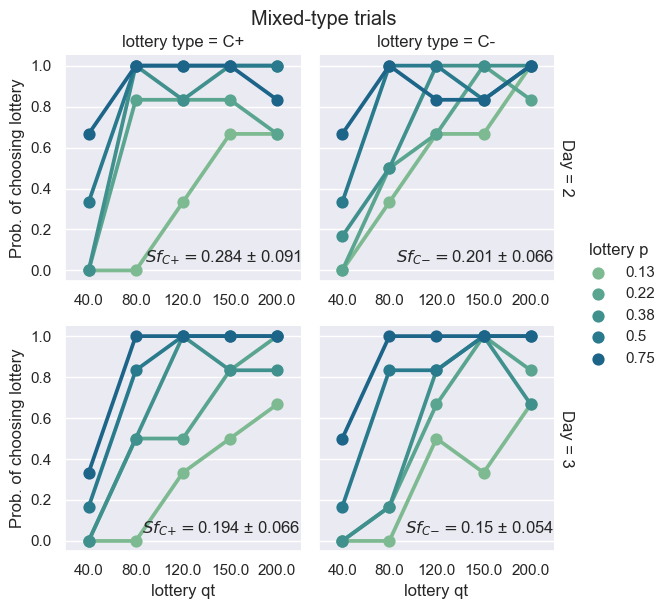

In [21]:
neuroEcon_mt_df = neuroEcon_df[neuroEcon_df['Trial Type'] == 'mixed']

grouped_mt_df = pd.DataFrame(neuroEcon_mt_df.groupby(['Day', 'lottery type', 'lottery p', 'lottery qt']).apply(lambda df: get_probLottery(df)), 
        columns = [probLotteryChoice_colName]).reset_index()
sns.set_theme(font_scale = 1)

fg = sns.catplot(data= grouped_mt_df, row = 'Day', col="lottery type", 
    x="lottery qt", y=probLotteryChoice_colName, hue="lottery p", 
    kind = 'point', palette = sns.color_palette("crest"),
    height=3, aspect = 1,
    sharex=False, margin_titles = True
    )

# add scaling factor labels
scFact_label = [r'$Sf_{C\plus}= $', r'$Sf_{C\minus}= $',
               r'$Sf_{C\plus}= $', r'$Sf_{C\minus}= $']
scFact_values = [parsCI_d2_MT[0], parsCI_d2_MT[1],
                parsCI_d3_MT[0], parsCI_d3_MT[1]]

c = 0
for ax in fg.axes.flat:  # iterate through each subplot
    ax.text(1,0.06, '{}{}'.format(scFact_label[c],scFact_values[c]), size=12, ha="right", va = 'bottom',
         transform=ax.transAxes)
    c+=1

plt.suptitle('Mixed-type trials', va = 'bottom');
plt.savefig(subject_figures_path_responses + '/mixedType_probPlots_scalFact.png')

### Mixed-type 

**Using propagation of uncertainty in parameter estimation** (the alphas for money, C+, and C- and the beta parameter were estimated with a 95% confidence interval)

In [21]:
parsCI_d2_ST, parsCI_d3_ST

(['0.626 ± 0.064', '0.317 ± 0.048', '0.057 ± 0.077', '4.345 ± 0.461'],
 ['0.329 ± 0.044', '0.037 ± 0.133', '0.335 ± 0.039', '5.292 ± 2.477'])

# Stability of risk parameters

Within subject (compare confidence intervals for )

To determine the stability of the risk parameters, we will perform a t-test to check for session effects (neuroeconomics task at day 2 and day 3) seperately for each reward type.

In [ ]:
# paired t-test (is there a difference in a group between two points in time)

# null hypothesis (H0): dependent sample means are equal (m1 = m2)
# alternative hypothesis (Ha): dependent sample means (m1!=m2)

from numpy.random import seed
from numpy.random import randn
from numpy.random import normal
from scipy.stats import ttest_rel

for i, risk_params in enumerate(zip(parsCI_d2_ST, parsCI_d3_ST)):
    if i < 3:
        # obtain the standard deviation
        risk_param_d2 = float(risk_params[0].split(' ')[0])
        interval_d2 = float(risk_params[0].split(' ')[-1])

        risk_param_d3 = float(risk_params[1].split(' ')[0])
        interval_d3 = float(risk_params[1].split(' ')[-1])

In [44]:
# use this code to implement a t-test for a simulated sample of alpha parameters
# e.g.: 50 alphas for money obtained from same type trials to create a sample  for which we can assume normality  

# paired t-test (is there a difference in a group between two points in time)

# null hypothesis (H0): dependent sample means are equal (m1 = m2)
# alternative hypothesis (Ha): dependent sample means (m1!=m2)

from numpy.random import seed
from numpy.random import randn
from numpy.random import normal
from scipy.stats import ttest_rel

# perform the paired t-test and extract the t statistic and the p-value
t_stat, p_value = ttest_rel(neuroeconTask_d2, neuroeconTask_d3)

# print those values
print(f'T-statistic value: {t_stat}')
print(f'P_value: {p_value}\n')

T-statistic value: 1.7034562077638693
P_value: 0.0916200222747145

T-statistic value: 1.3650573557362027
P_value: 0.17532918978744882

T-statistic value: -1.646600629562299
P_value: 0.1028110814449738

